In [24]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import os, sys
from glob import glob
from os.path import join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=False)
import h5py
import json
from tqdm.notebook import tqdm

import dataframe_image as dfi

In [26]:
from ukbb2020_dataloader import UKBB2020

In [27]:
sys.path.insert(0, "../../helper/")
from plotGraphs import *
from plotResults import plot_result

In [28]:
SAVE_DIR_2000 = "/ritter/share/projects/gonzalo/python_files/ML_for_alcohol_misuse/CNNpipeline/results/UKBB_35k_2000_cuda02-h5files5tasks2000_moodbalanced/good_one/run.csv"
SAVE_DIR_250 = "/ritter/share/projects/gonzalo/python_files/ML_for_alcohol_misuse/CNNpipeline/results/UKBB_35k_250_cuda02-h5files5tasks250_moodbalanced/20220808-1658/run.csv"
SAVE_DIR_8000 = "/ritter/share/projects/gonzalo/python_files/ML_for_alcohol_misuse/CNNpipeline/results/UKBB_35k_8000_cuda01-h5files5tasks8000_moodbalanced/sex/run_extended.csv"

In [29]:
df2000 = pd.read_csv(SAVE_DIR_2000)
df250 = pd.read_csv(SAVE_DIR_250)
df8000 = pd.read_csv(SAVE_DIR_8000)

In [30]:
#nsamples250 = [250] * 105
#nsamples2000 = [2000] * 105
df = pd.concat([df250, df2000, df8000], ignore_index=True)
dfred = df[['model_unique_name','out', 'n_samples', 'm__criterion', 'val_accuracy_score','val_balanced_accuracy_score', 'val_explained_variance_score', 'runtime']].copy()

model_unique_name =df['model_unique_name'].tolist()
finetuning = ['FiTu'] * len(model_unique_name)
feature_extraction = ['Fe_Ex'] * len(model_unique_name)
baseline = ['baseline'] * len(model_unique_name)
MRI = ['MRI'] * len(model_unique_name)
videos = ['videos'] * len(model_unique_name)
SS = ['SS'] * len(model_unique_name)

dfred = dfred.rename(columns = {'runtime': "runtime(s)" })
                                        
dfred['val_metric'] = dfred['val_balanced_accuracy_score'][(dfred['out'] == 'sex')]
dfred['val_metric'].update(dfred['val_balanced_accuracy_score'][(dfred['out'] == 'mood_disorder')])
dfred['val_metric'].update(dfred['val_accuracy_score'][(dfred['out'] == 'srt_right_ear_classification')])
dfred['val_metric'].update(dfred['val_accuracy_score'][(dfred['out'] == 'alc_int_freq')])
dfred['val_metric'].update(dfred['val_explained_variance_score'][(dfred['out'] == 'mean_fa_fornix')])

dfredtemp1 = dfred.copy()
dfredtemp2 = dfred.copy()
dfredtemp3 = dfred.copy()
dfredtemp1['TL_type'] = feature_extraction
dfredtemp2['TL_type'] = finetuning

dfredtemp1['Pre-trained'] = MRI
dfredtemp2['Pre-trained'] = videos
dfredtemp3['Pre-trained'] = SS

dfred['TL_type'] = baseline
dfred['TL_type'].update(dfredtemp1['TL_type'][dfred['model_unique_name'].str.contains('feature_extraction')])
dfred['TL_type'].update(dfredtemp2['TL_type'][dfred['model_unique_name'].str.contains('finetuning')])
            
dfred['Pre-trained']= baseline
dfred['Pre-trained'].update(dfredtemp1['Pre-trained'][dfred['model_unique_name'].str.contains('MRI')])
dfred['Pre-trained'].update(dfredtemp2['Pre-trained'][dfred['model_unique_name'].str.contains('videos')])
dfred['Pre-trained'].update(dfredtemp3['Pre-trained'][dfred['model_unique_name'].str.contains('Self')])

difficulty = [0] * len(model_unique_name)
dfred['difficulty'] = difficulty

In [31]:
dfred['difficulty'][(dfred['out'] == 'sex')] = [0] * len(model_unique_name)
dfred['difficulty'][(dfred['out'] == 'mean_fa_fornix')] = [1] * len(model_unique_name)
dfred['difficulty'][(dfred['out'] == 'srt_right_ear_classification')] = [2] * len(model_unique_name)
dfred['difficulty'][(dfred['out'] == 'mood_disorder')] = [3] * len(model_unique_name) 
dfred['difficulty'][(dfred['out'] == 'alc_int_freq')] = [4] * len(model_unique_name)

dfred['model_unique_name'] = df['model_unique_name'].str.replace('ResNet50', 'R50')

dfred = dfred.sort_values(['difficulty', 'n_samples']) #, 'model_unique_name', 'val_metric'])

#dfred = dfred[dfred['val_metric'].notna()]
dfred

/tmp/ipykernel_3204106/1827912584.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfred['difficulty'][(dfred['out'] == 'sex')] = [0] * len(model_unique_name)
/tmp/ipykernel_3204106/1827912584.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfred['difficulty'][(dfred['out'] == 'mean_fa_fornix')] = [1] * len(model_unique_name)
/tmp/ipykernel_3204106/1827912584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfred['difficulty'

,model_unique_name,out,n_samples,m__criterion,val_accuracy_score,val_balanced_accuracy_score,val_explained_variance_score,runtime(s),val_metric,TL_type,Pre-trained,difficulty
9,R50_MRI_feature_extraction,sex,250,BCEWithLogitsLoss({'reduction': 'mean'}),0.554217,0.542303,NaN,233,0.542303,Fe_Ex,MRI,0
10,R50_MRI_feature_extraction,sex,250,BCEWithLogitsLoss({'reduction': 'mean'}),0.638554,0.605170,NaN,149,0.605170,Fe_Ex,MRI,0
11,R50_MRI_feature_extraction,sex,250,BCEWithLogitsLoss({'reduction': 'mean'}),0.559524,0.543128,NaN,171,0.543128,Fe_Ex,MRI,0
24,R50_MRI_finetuning,sex,250,BCEWithLogitsLoss({'reduction': 'mean'}),0.845238,0.850201,NaN,353,0.850201,FiTu,MRI,0
25,R50_MRI_finetuning,sex,250,BCEWithLogitsLoss({'reduction': 'mean'}),0.987952,0.989130,NaN,315,0.989130,FiTu,MRI,0
...,...,...,...,...,...,...,...,...,...,...,...,...
286,R50_videos_feature_extraction,alc_int_freq,8000,"CrossEntropyLoss({'reduction': 'mean', 'weight...",NaN,NaN,NaN,170,NaN,Fe_Ex,videos,4
287,R50_videos_feature_extraction,alc_int_freq,8000,CrossEntropyLoss({'weight':[0.7220868309414207...,0.402101,NaN,NaN,15920,0.402101,Fe_Ex,videos,4
306,R50_videos_finetuning,alc_int_freq,8000,CrossEntropyLoss({'weight':[0.7220868309414207...,0.461567,NaN,NaN,15720,0.461567,FiTu,videos,4
307,R50_videos_finetuning,alc_int_freq,8000,CrossEntropyLoss({'weight':[0.7220868309414207...,0.477315,NaN,NaN,51671,0.477315,FiTu,videos,4


In [32]:
out = pd.unique(dfred['out'].tolist())
model_unique_name = pd.unique(dfred['model_unique_name'].tolist())
val_accuracy_score= dfred['val_accuracy_score'].tolist()
#val_accuracy_score_2000 = dfred['val_accuracy_score_2000'].tolist()

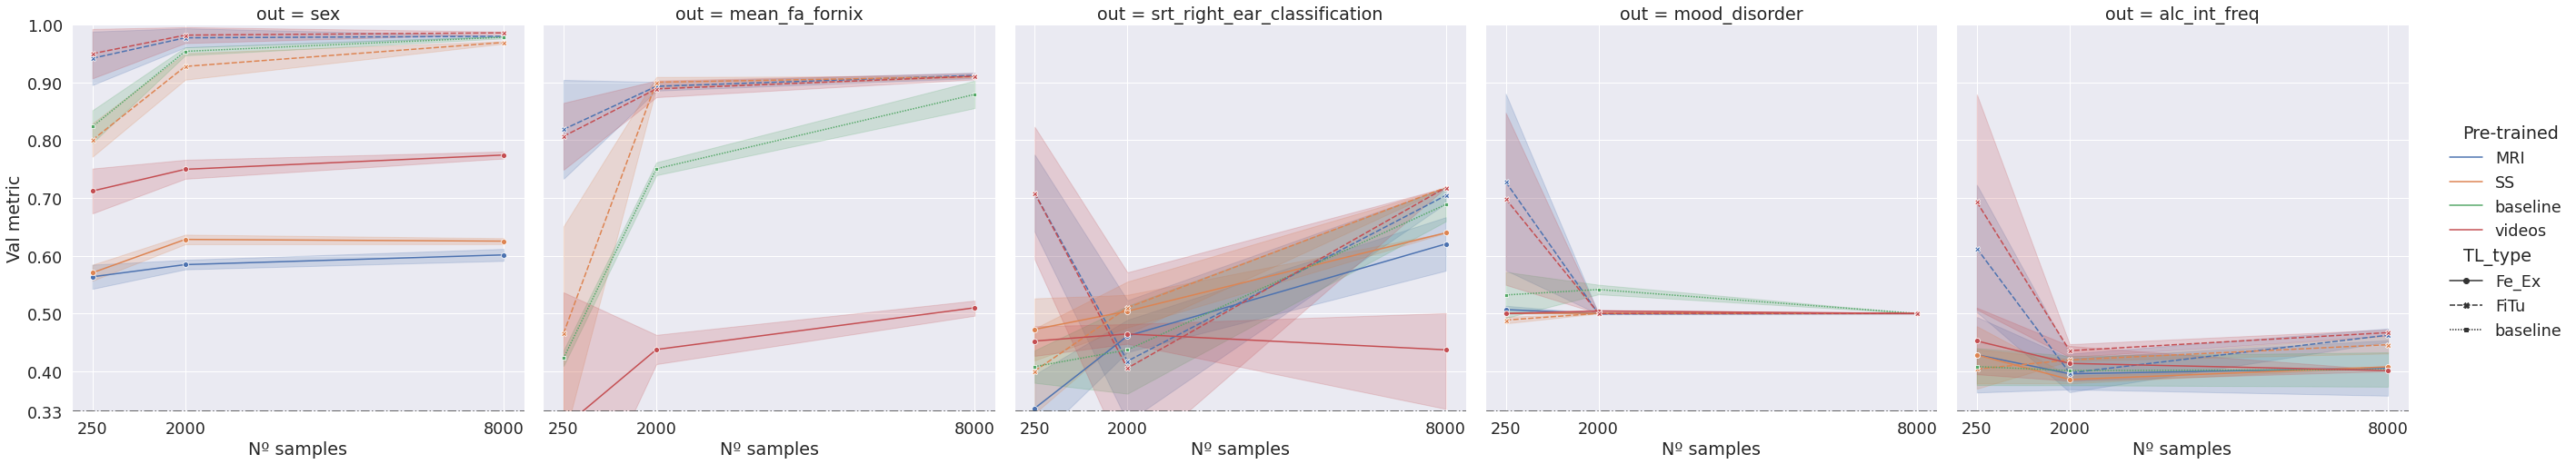

In [20]:
sns.set(font_scale=1.6)
g = sns.relplot(kind='line',
           data=dfred, #[(dfred['out'] == 'sex') or (dfred['out'] == 'mood_disorder')],
           x='n_samples', y='val_metric', hue='Pre-trained',style = 'TL_type', col ='out', height = 7.5, err_style='band', ci=90, markers = True ) 

(g.map(plt.axhline, y=0.33, ls = '-.', c= 'k', label = 'Chance')
  .set_axis_labels("Nº samples", "Val metric"))
 # .set_titles("Task: {col_name}"))
    
sns.set(font_scale=1.6)
    
plt.ylim(0.33,1)
#g.set(xscale="log")
plt.sharey = False
#plt.legend()
g.set(xticks=(250,2000,8000), yticks =(0.33, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0))
plt.savefig('5_tasks_metrics_over_samples.png')
plt.show()

In [11]:
#Increse font size of text, x axes 3 ticks, increase the alpha of the confidence figure, thicker lines, change color to only 4,
#change the confidence interval to intervals with lines

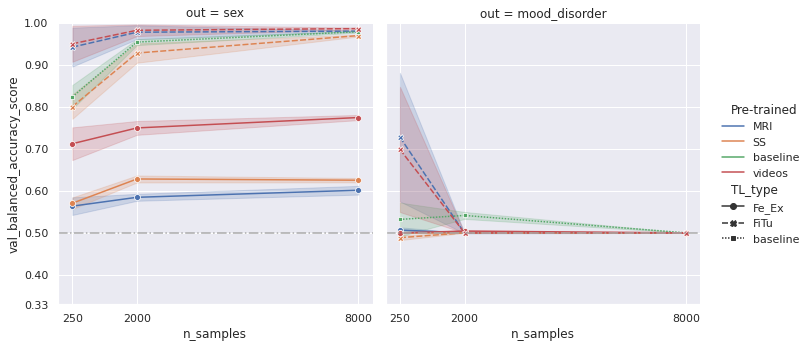

In [17]:
sns.set(font_scale=1)
g = sns.relplot(kind='line',
           data=dfred[dfred['m__criterion'].str.contains('BCE')], #[(dfred['out'] == 'sex') or (dfred['out'] == 'mood_disorder')],
           x='n_samples', y='val_balanced_accuracy_score', hue='Pre-trained', style = 'TL_type', col ='out', ci=90, markers = True)

(g.map(plt.axhline, y=0.5, ls = '-.', c= 'darkgray', label = 'Chance Categorical'))

plt.ylim(0.33,1)
plt.sharey = False
g.set(xticks=(250,2000,8000), yticks =(0.33, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0))
plt.savefig('binary_task.png')
plt.show()

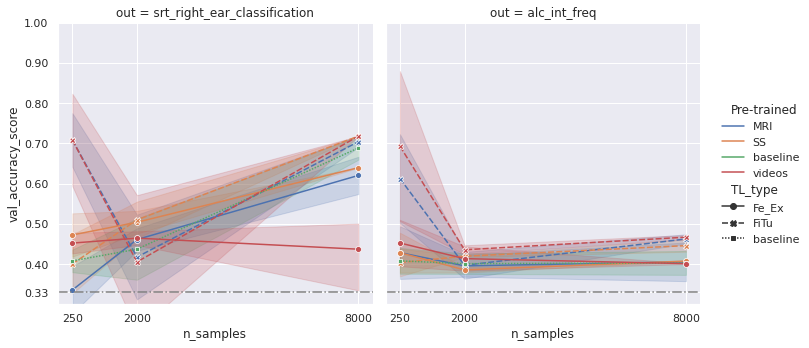

In [18]:
g = sns.relplot(kind='line',
           data=dfred[dfred['m__criterion'].str.contains('Cross')], #[(dfred['out'] == 'sex') or (dfred['out'] == 'mood_disorder')],
           x='n_samples', y='val_accuracy_score', hue='Pre-trained', style = 'TL_type', col ='out',ci=90, markers = True)

(g.map(plt.axhline, y=0.33, ls = '-.', c= 'grey', label = 'Chance'))
plt.ylim(0.30,1)
plt.sharey = False
g.set(xticks=(250,2000,8000), yticks =(0.33, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0))
plt.savefig('categorical.png')
plt.show()

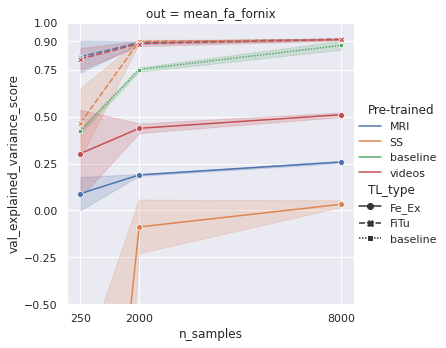

In [19]:
g = sns.relplot(kind='line',
           data=dfred[dfred['m__criterion'].str.contains('MSELoss')], #[(dfred['out'] == 'sex') or (dfred['out'] == 'mood_disorder')],
           x='n_samples', y='val_explained_variance_score', hue='Pre-trained', style = 'TL_type', ci=90, col ='out', markers = True)

plt.ylim(-0.5,1)
plt.sharey = False
g.set(xticks=(250,2000,8000), yticks =(-0.5,-0.25, 0,0.25, 0.5, 0.75, 0.9, 1.0))
plt.savefig('regression_task.png')
plt.show()

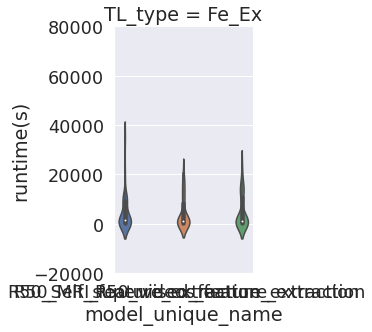

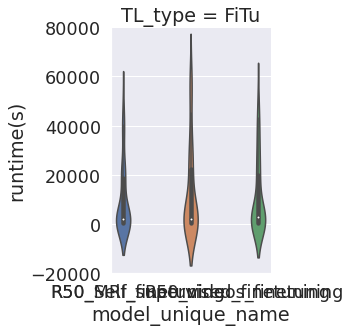

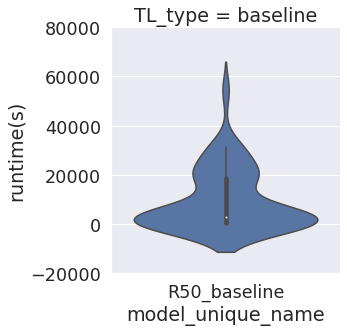

In [15]:
TL_type = pd.unique(dfred['TL_type'].tolist())

for types in TL_type : 
    g = sns.catplot(kind='violin',
               data=dfred[(dfred['TL_type'] == types)],#[(dfred['out'] == 'sex')] ,
               x='model_unique_name', y="runtime(s)", hue='model_unique_name', style = 'TL_type', col ='TL_type')
    plt.ylim(-20000,80000)
plt.sharey = True
#plt.ylim(-20000,60000)
plt.savefig('runtime.png')
plt.show()

/tmp/ipykernel_3204106/539611084.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=dfred[(dfred['TL_type'] == 'Fe_Ex')][(dfred['out'] == 'sex')] ,


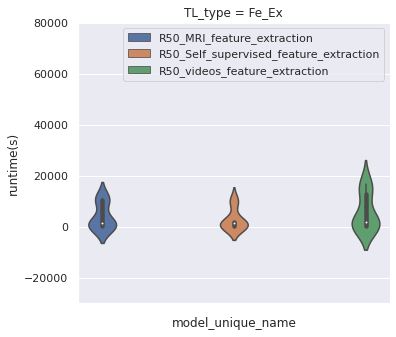

In [34]:
from matplotlib import rcParams
g = sns.catplot(kind='violin',
           data=dfred[(dfred['TL_type'] == 'Fe_Ex')][(dfred['out'] == 'sex')] ,
           x='model_unique_name', y="runtime(s)", hue='model_unique_name', style = 'TL_type', col ='TL_type', height=5, aspect=1.2)

g.set_xticklabels([])
#[plt.setp(ax.get_xticklabels(), rotation=90, ha="right") for ax in g.axes.flat]
#[plt.setp() for ax in g.axes.flat]
plt.sharey = True
plt.ylim(-30000,80000)
plt.legend()
plt.savefig('runtime_ft_ex.png')
plt.show()

/tmp/ipykernel_3204106/1103562062.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=dfred[(dfred['TL_type'] == 'FiTu')][(dfred['out'] == 'sex')] ,


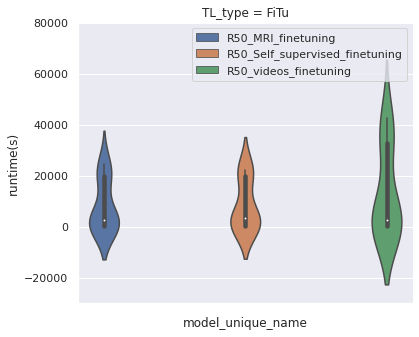

In [36]:
g = sns.catplot(kind='violin',
           data=dfred[(dfred['TL_type'] == 'FiTu')][(dfred['out'] == 'sex')] ,
           x='model_unique_name', y="runtime(s)", hue='model_unique_name', style = 'TL_type', col ='TL_type', height=5, aspect=1.2)
plt.sharey = True
plt.ylim(-30000,80000)
g.set_xticklabels([])
plt.legend()
plt.savefig('runtime_FiTu.png')
plt.show()

/tmp/ipykernel_3204106/2250306473.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=dfred[(dfred['TL_type'] == 'baseline')][(dfred['out'] == 'sex')] ,


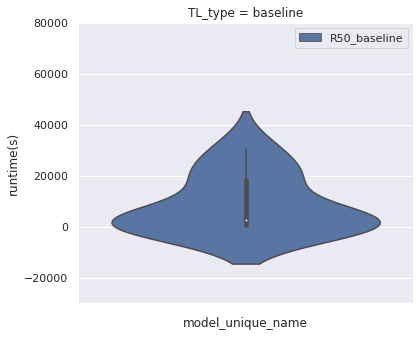

In [37]:
g = sns.catplot(kind='violin',
           data=dfred[(dfred['TL_type'] == 'baseline')][(dfred['out'] == 'sex')] ,
           x='model_unique_name', y="runtime(s)", hue='model_unique_name', style = 'TL_type', col ='TL_type', height=5, aspect=1.2)
plt.sharey = True
plt.ylim(-30000,80000)
g.set_xticklabels([])
plt.legend()
plt.savefig('runtime_baseline.png')
plt.show()

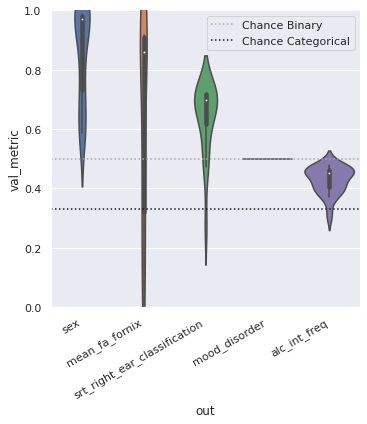

In [42]:
g = sns.catplot(kind='violin',
           data=dfred[(dfred['n_samples']==8000)] ,
           x='out', y="val_metric", height=5, aspect=1.1, legend = False)
(g.map(plt.axhline, y=0.5, ls = ':', c= 'darkgray', label = 'Chance Binary'))
(g.map(plt.axhline, y=0.33, ls = ':', c= 'k', label = 'Chance Categorical'))

plt.sharey = True
plt.ylim(0,1)
[plt.setp(ax.get_xticklabels(), rotation=30, ha="right") for ax in g.axes.flat]
plt.legend()
plt.savefig('difficulty.png', bbox_inches='tight')
plt.show()

In [20]:
#

array(['feature_extraction', 'finetuning', 'baseline'], dtype=object)

In [17]:
import plotly.figure_factory as ff
dfprint = dfred[['model_unique_name','out', 'n_samples', 'val_metric']].copy()

#dfprint['std'] = dfprint[dfprint['n_samples']

dfprint['model_unique_name'] = dfprint['model_unique_name'].str.replace('feature_extraction', 'FtEx')

#dfprint = dftemp.copy()
dfprint['model_unique_name'] = dfprint['model_unique_name'].str.replace('finetuning', 'FiTu')

fig =  ff.create_table(dfprint)
fig.update_layout(
    autosize=True,
 #   width=1500,
 #   height=6460,
 #   font={'size':16}
)
fig.write_image("table_plotly.png", scale=2)

In [18]:
dfprint

,model_unique_name,out,n_samples,val_metric
9,R50_MRI_FtEx,sex,250,0.542303
10,R50_MRI_FtEx,sex,250,0.605170
11,R50_MRI_FtEx,sex,250,0.543128
24,R50_MRI_FiTu,sex,250,0.850201
25,R50_MRI_FiTu,sex,250,0.989130
...,...,...,...,...
286,R50_videos_FtEx,alc_int_freq,8000,NaN
287,R50_videos_FtEx,alc_int_freq,8000,0.402101
306,R50_videos_FiTu,alc_int_freq,8000,0.461567
307,R50_videos_FiTu,alc_int_freq,8000,0.477315


In [19]:
dfprint.to_excel('df.xlsx',index=False)

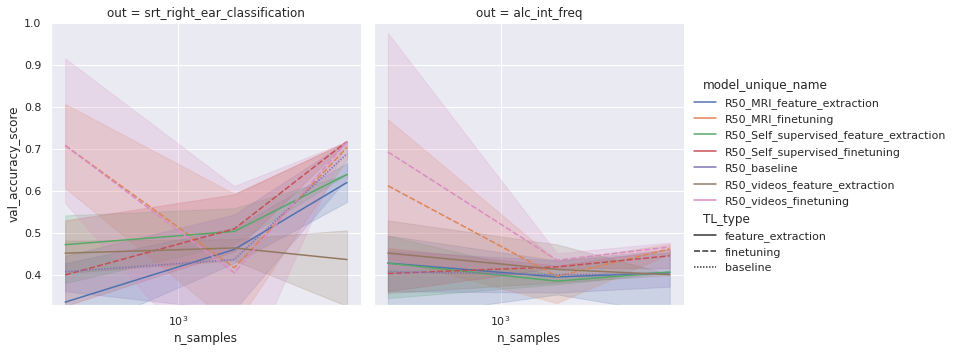

In [23]:
g = sns.relplot(kind='line',
           data=dfred[dfred['m__criterion'].str.contains('Cross')], #[(dfred['out'] == 'sex') or (dfred['out'] == 'mood_disorder')],
           x='n_samples', y='val_accuracy_score', hue='model_unique_name', style = 'TL_type', col ='out')
plt.ylim(0.33,1)
g.set(xscale="log")
plt.sharey = False
plt.savefig('multicategorical.png')
plt.show()

In [ ]:
sns.catplot(kind='point',
           data=dfred, 
           x='model_unique_name', y='val_metric')

In [ ]:
df2000['val_metric'] = dfred['val_balanced_accuracy_score'][(dfred['out'] == 'sex')]
df2000['val_metric'].update(dfred['val_balanced_accuracy_score'][(dfred['out'] == 'mood_disorder')])
df2000['val_metric'].update(dfred['val_accuracy_score'][(dfred['out'] == 'srt_right_ear_classification')])
df2000['val_metric'].update(dfred['val_accuracy_score'][(dfred['out'] == 'alc_int_freq')])
df2000['val_metric'].update(dfred['val_explained_variance_score'][(dfred['out'] == 'mean_fa_fornix')])